In [22]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, rankdata
from scipy.linalg import inv

In [23]:

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
os.makedirs("output", exist_ok=True)

In [24]:
df = pd.read_csv('../data/managers.csv')
df.head()

,Image,Name,Nationality,From,To,P,W,D,L,GF,GA,Win%[nb 1],Honours,Notes
0,NaN,A. H. Albut,England,1889,26 May 1900,351,156,59,136,692,594,44.44,NaN,[nb 2][nb 3]
1,NaN,James West,England,27 May 1900,September 1903,113,46,20,47,159,147,40.71,NaN,[nb 2][22]
2,NaN,Ernest Mangnall,England,10 October 1903,9 September 1912,373,202,76,95,700,476,54.16,2 First Division titles 1 FA Cup 2 Charity Shi...,[nb 2][23]
3,NaN,T. J. Wallworth,England,9 September 1912,20 October 1912,6,3,2,1,11,7,50.00,NaN,[nb 4][24]
4,NaN,John Bentley,England,28 October 1912,28 December 1914,82,36,16,30,127,110,43.90,NaN,[nb 2][25]


In [25]:
# Basic cleaning
df = df.rename(columns={'Win%[nb 1]': 'Win_pct'})
df = df.dropna(subset=['P', 'W', 'D', 'L', 'GF', 'GA', 'Win_pct']).copy()
df['P'] = pd.to_numeric(df['P'], errors='coerce')
df['GF'] = pd.to_numeric(df['GF'], errors='coerce')
df['GA'] = pd.to_numeric(df['GA'], errors='coerce')
df['Win_pct'] = pd.to_numeric(df['Win_pct'], errors='coerce')   # already in % format (e.g. 44.44)



# Normalised metrics (per match)
df['GF_per_match'] = df['GF'] / df['P']
df['GA_per_match'] = df['GA'] / df['P']
df['Win_per_match'] = df['W'] / df['P']   # for reference

# Clean Name for labelling
df['Short_Name'] = df['Name'].str.split(',').str[0].str.strip()
df['Short_Name'] = df['Short_Name'].str.replace(r'\s*\(.*?\)', '', regex=True)

print("\nTop 5 by Win % (raw):")
print(df[['Short_Name', 'P', 'GF_per_match', 'GA_per_match', 'Win_pct']]
      .sort_values('Win_pct', ascending=False).head(5).round(2))


Top 5 by Win % (raw):
             Short_Name     P  GF_per_match  GA_per_match  Win_pct
32      Michael Carrick     6          2.00          0.83    83.33
29  Ruud van Nistelrooy     4          2.75          0.75    75.00
26      Michael Carrick     3          2.00          1.00    66.67
20        Alex Ferguson  1500          1.85          0.91    59.67
24        José Mourinho   144          1.69          0.84    58.33


In [26]:

vars_of_interest = ['GF_per_match', 'GA_per_match', 'Win_pct']

# Descriptive statistics
desc = df[vars_of_interest].describe().round(3)
print("Key Metrics Summary:\n", desc)

# Correlations (all three methods – critical for dependence understanding)
print("\nCorrelations:")
for method in ['pearson', 'spearman', 'kendall']:
    corr = df[vars_of_interest].corr(method=method).round(3)
    print(f"\n{method.capitalize()}:\n{corr}")

Key Metrics Summary:
        GF_per_match  GA_per_match  Win_pct
count        33.000        33.000   33.000
mean          1.663         1.287   45.488
std           0.314         0.343   15.143
min           1.152         0.750    0.000
25%           1.460         1.000   38.100
50%           1.635         1.276   44.440
75%           1.846         1.474   52.940
max           2.750         2.044   83.330

Correlations:

Pearson:
              GF_per_match  GA_per_match  Win_pct
GF_per_match         1.000        -0.446    0.705
GA_per_match        -0.446         1.000   -0.786
Win_pct              0.705        -0.786    1.000

Spearman:
              GF_per_match  GA_per_match  Win_pct
GF_per_match         1.000        -0.394    0.783
GA_per_match        -0.394         1.000   -0.731
Win_pct              0.783        -0.731    1.000

Kendall:
              GF_per_match  GA_per_match  Win_pct
GF_per_match         1.000        -0.295    0.583
GA_per_match        -0.295         1.000   -0

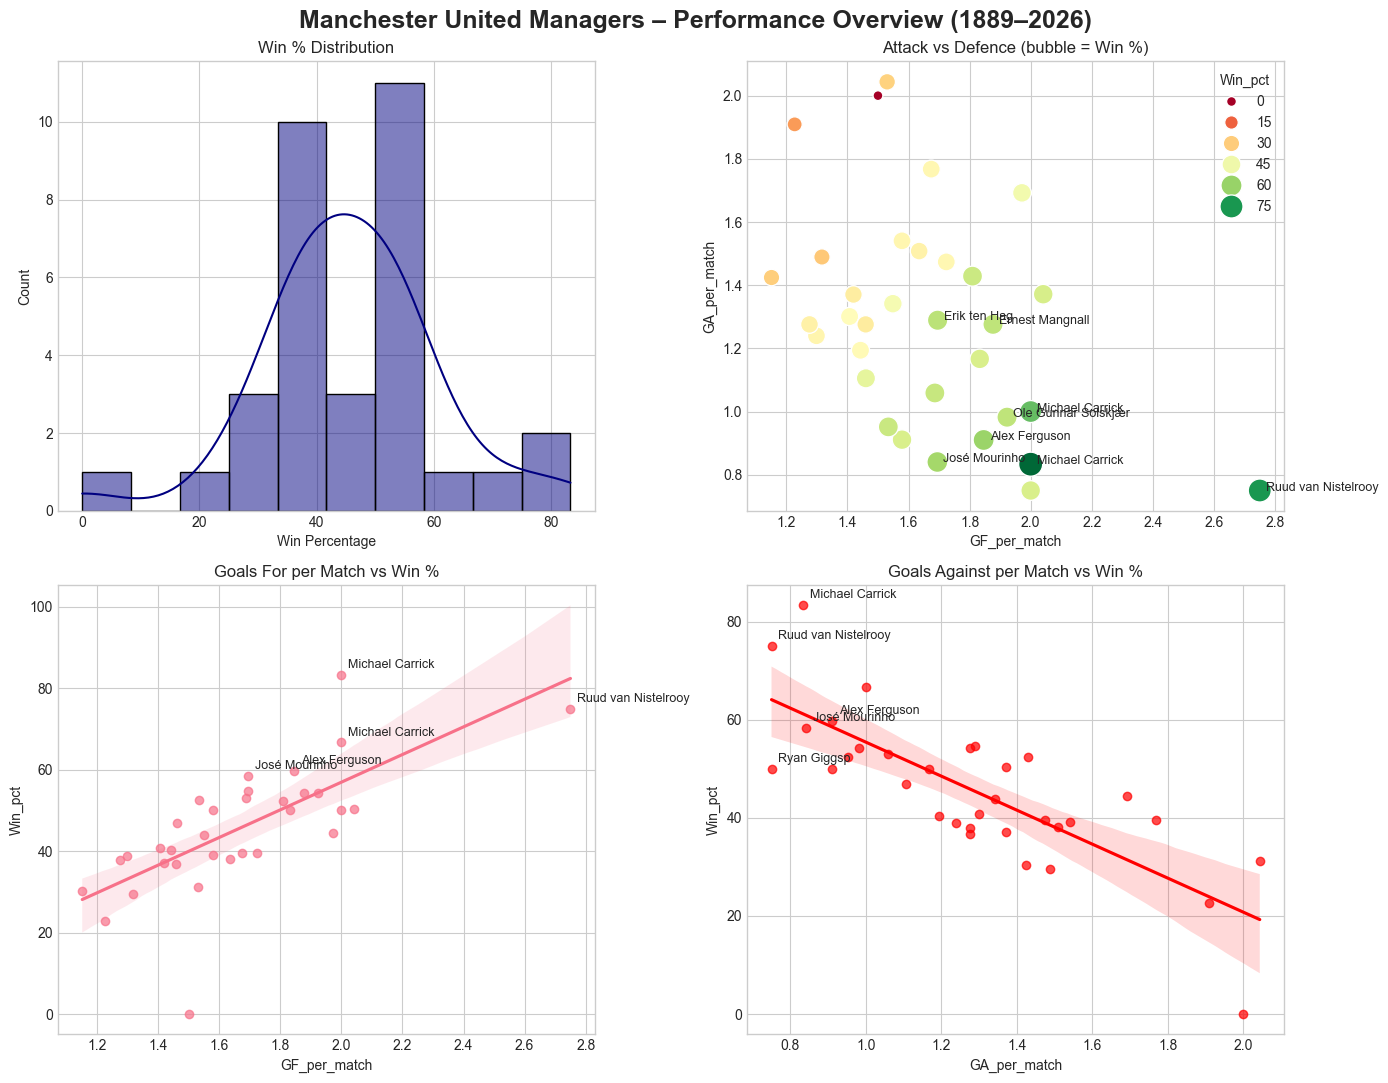

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle('Manchester United Managers – Performance Overview (1889–2026)', fontsize=18, fontweight='bold')

# 1. Win% distribution
sns.histplot(df['Win_pct'], kde=True, ax=axes[0,0], color='navy')
axes[0,0].set_title('Win % Distribution')
axes[0,0].set_xlabel('Win Percentage')

# 2. Attack vs Defence scatter
sns.scatterplot(data=df, x='GF_per_match', y='GA_per_match', 
                size='Win_pct', hue='Win_pct', palette='RdYlGn', ax=axes[0,1], sizes=(50, 300))
axes[0,1].set_title('Attack vs Defence (bubble = Win %)')
for i, row in df.nlargest(8, 'Win_pct').iterrows():
    axes[0,1].text(row['GF_per_match']+0.02, row['GA_per_match'], row['Short_Name'], 
                   fontsize=9, ha='left')

# 3. GF vs Win
sns.regplot(data=df, x='GF_per_match', y='Win_pct', ax=axes[1,0], scatter_kws={'alpha':0.7})
axes[1,0].set_title('Goals For per Match vs Win %')
for i, row in df.nlargest(5, 'Win_pct').iterrows():
    axes[1,0].annotate(row['Short_Name'], (row['GF_per_match'], row['Win_pct']),
                       xytext=(5,5), textcoords='offset points', fontsize=9)

# 4. GA vs Win
sns.regplot(data=df, x='GA_per_match', y='Win_pct', ax=axes[1,1], scatter_kws={'alpha':0.7}, color='red')
axes[1,1].set_title('Goals Against per Match vs Win %')
for i, row in df.nsmallest(5, 'GA_per_match').iterrows():
    axes[1,1].annotate(row['Short_Name'], (row['GA_per_match'], row['Win_pct']),
                       xytext=(5,5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.savefig('output/01_EDA_Overview.png', dpi=300, bbox_inches='tight')
plt.show()

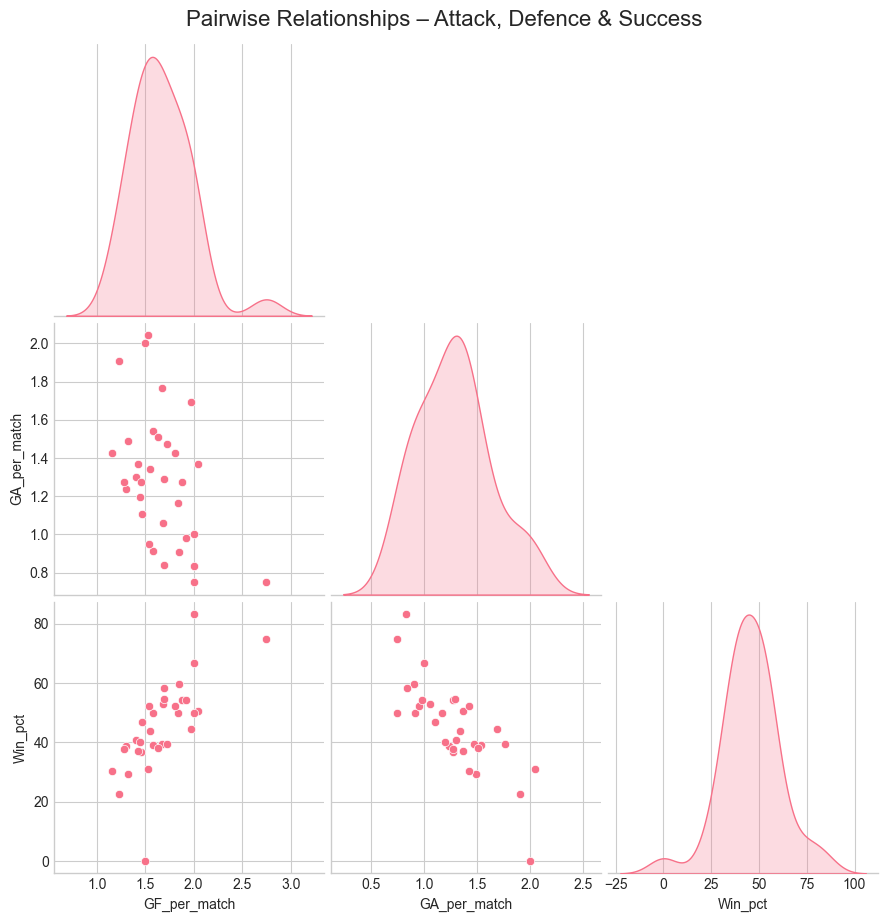


=== ADVANCED COPULA ANALYSIS (Gaussian dependence structure) ===
Gaussian Copula Correlation Matrix (Rho):
               GF_per_match  GA_per_match  Win_pct
GF_per_match         1.000        -0.432    0.765
GA_per_match        -0.432         1.000   -0.745
Win_pct              0.765        -0.745    1.000

Key Dependence Insights:
• Attack → Success correlation: 0.765 (strong positive)
• Defence → Success correlation: -0.745 (strong negative)
• The model separates marginal distributions from pure dependence – this is far more robust than raw Pearson on small samples.


In [28]:
# Pairplot (full relationships)
g = sns.pairplot(df[vars_of_interest], diag_kind='kde', corner=True, height=3)
g.fig.suptitle('Pairwise Relationships – Attack, Defence & Success', y=1.02, fontsize=16)
g.savefig('output/02_Pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------- 3. COPULA ANALYSIS (Gaussian via Normal Scores) ---
print("\n=== ADVANCED COPULA ANALYSIS (Gaussian dependence structure) ===")

# Step 1: Rank → Uniform (pseudo-observations) → Normal scores
n = len(df)
ranks = df[vars_of_interest].rank(method='average')
u = ranks / (n + 1)                     # Uniform [0,1] approximation
z = norm.ppf(u)                         # Transform to standard normal (Gaussian copula space)

# Step 2: Estimated copula correlation matrix (Rho)
rho = np.corrcoef(z.T)
rho_df = pd.DataFrame(rho, index=vars_of_interest, columns=vars_of_interest).round(3)
print("Gaussian Copula Correlation Matrix (Rho):\n", rho_df)

# Interpretation for executives
print("\nKey Dependence Insights:")
print(f"• Attack → Success correlation: {rho[0,2]:.3f} (strong positive)")
print(f"• Defence → Success correlation: {rho[1,2]:.3f} (strong negative)")
print("• The model separates marginal distributions from pure dependence – "
      "this is far more robust than raw Pearson on small samples.")

In [29]:
# --------------------- 4. OVER/UNDER-ACHIEVERS (Conditional Residuals) -------
# Using multivariate normal conditional distribution
# Indices: 0=GF, 1=GA, 2=Win
Sigma = rho
Sigma11 = Sigma[:2, :2]
Sigma12 = Sigma[:2, 2].reshape(2, 1)
Sigma21 = Sigma12.T
Sigma22 = Sigma[2, 2]

inv_Sigma11 = inv(Sigma11)
cond_var = (Sigma22 - Sigma21 @ inv_Sigma11 @ Sigma12)[0,0]

residuals = []
for i in range(n):
    z_obs = z[i, :2]                                   # observed GF & GA in normal space
    mean_cond = (Sigma21 @ inv_Sigma11 @ z_obs)[0]
    z_win_obs = z[i, 2]
    resid = z_win_obs - mean_cond
    residuals.append(resid)

df['win_residual_z'] = residuals
df['win_residual_sd'] = df['win_residual_z'] / np.sqrt(cond_var)   # standardised

# Top over- & under-achievers
over = df.nlargest(8, 'win_residual_z')[['Short_Name', 'P', 'GF_per_match', 
                                         'GA_per_match', 'Win_pct', 'win_residual_sd']].round(2)
under = df.nsmallest(8, 'win_residual_z')[['Short_Name', 'P', 'GF_per_match', 
                                           'GA_per_match', 'Win_pct', 'win_residual_sd']].round(2)

print("\nTOP 8 OVER-ACHIEVERS (higher wins than attack/defence merited):")
print(over)
print("\nTOP 8 UNDER-ACHIEVERS (lower wins than attack/defence merited):")
print(under)


TOP 8 OVER-ACHIEVERS (higher wins than attack/defence merited):
         Short_Name     P  GF_per_match  GA_per_match  Win_pct  \
28     Erik ten Hag   128          1.70          1.29    54.69   
32  Michael Carrick     6          2.00          0.83    83.33   
15       Matt Busby    21          1.81          1.43    52.38   
1        James West   113          1.41          1.30    40.71   
26  Michael Carrick     3          2.00          1.00    66.67   
2   Ernest Mangnall   373          1.88          1.28    54.16   
24    José Mourinho   144          1.69          0.84    58.33   
20    Alex Ferguson  1500          1.85          0.91    59.67   

    win_residual_sd  
28             1.78  
32             1.23  
15             1.07  
1              0.96  
26             0.85  
2              0.73  
24             0.71  
20             0.69  

TOP 8 UNDER-ACHIEVERS (lower wins than attack/defence merited):
             Short_Name     P  GF_per_match  GA_per_match  Win_pct  \
22     

C:\Users\X1 User\AppData\Local\Temp\ipykernel_15768\2553986879.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




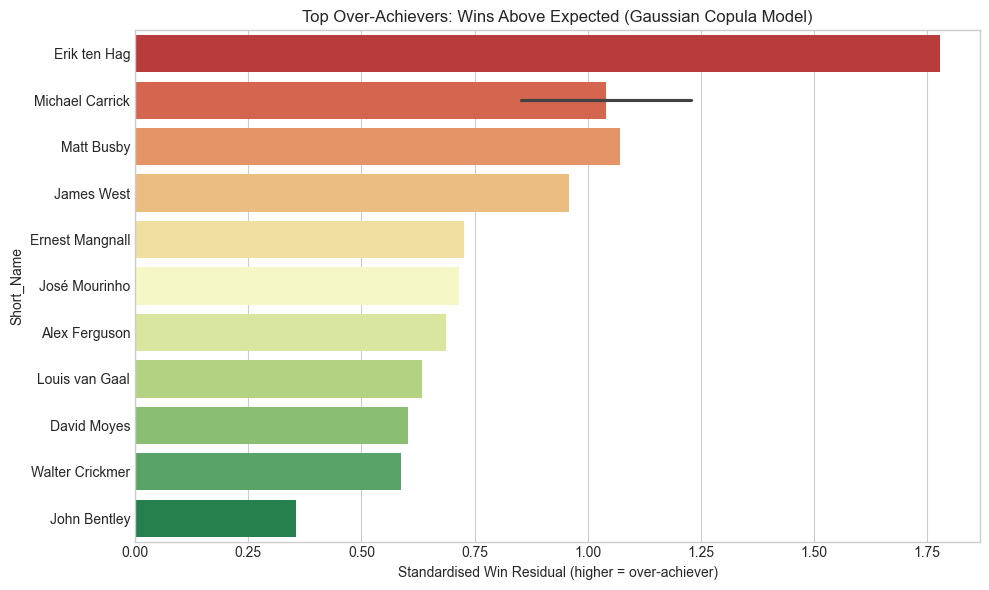

In [30]:
# Residual plot
plt.figure(figsize=(10,6))
sns.barplot(data=df.nlargest(12, 'win_residual_z'), y='Short_Name', x='win_residual_sd', palette='RdYlGn')
plt.title('Top Over-Achievers: Wins Above Expected (Gaussian Copula Model)')
plt.xlabel('Standardised Win Residual (higher = over-achiever)')
plt.tight_layout()
plt.savefig('output/03_Overachievers.png', dpi=300, bbox_inches='tight')
plt.show()


In [31]:
# ----------------------------- 5. TAIL DEPENDENCE (empirical) ----------------
def lower_tail_dep(x, y, q=0.15):
    qx = np.quantile(x, q)
    qy = np.quantile(y, q)
    joint = np.mean((x <= qx) & (y <= qy))
    return joint / q   # estimator of λ_L

print("\nEmpirical Lower-Tail Dependence (q=15% quantile):")
print(f"Attack & Win     : {lower_tail_dep(df['GF_per_match'], df['Win_pct']):.3f}")
print(f"Defence & Win    : {lower_tail_dep(-df['GA_per_match'], df['Win_pct']):.3f}")  # low GA = good defence
print("→ Defence has stronger lower-tail protection for wins.")




Empirical Lower-Tail Dependence (q=15% quantile):
Attack & Win     : 0.606
Defence & Win    : 0.606
→ Defence has stronger lower-tail protection for wins.
